# Prepare

In [ ]:
!pip install gdown

In [ ]:
!rm -rf /content/*.png
!rm -rf /content/*.jpg
!rm -rf /content/*.json
!rm -rf /content/*.txt
!rm -rf /content/*.py
!rm -rf /content/images
!rm -rf /content/AllFiles.zip

In [ ]:
import gdown
import os

allFiles_zip_url = "https://drive.google.com/uc?id=1YFgdnvm8HhQd6rXVxM8r9athmuuLfQym" # Version 0
# allFiles_zip_url = "https://drive.google.com/uc?id=1Iib-XuvdLBCBs6E_r9IMzaMkUZi2aBFA" # Version 1
# allFiles_zip_url = "https://drive.google.com/uc?id=1qLepdh40QfgKMJsCEqgufft-RnGRhJs2" # Version 2
gdown.download(allFiles_zip_url, "/content/AllFiles.zip", quiet=False)
!unzip /content/AllFiles.zip -d /content/

Downloading...
From: https://drive.google.com/uc?id=1qLepdh40QfgKMJsCEqgufft-RnGRhJs2
To: /content/AllFiles.zip
100%|██████████| 716k/716k [00:00<00:00, 48.0MB/s]

Archive:  /content/AllFiles.zip
  inflating: /content/explain.py     
  inflating: /content/fool.py        
  inflating: /content/imagenet-simple-labels.json  
  inflating: /content/images/broccoli.jpg  
  inflating: /content/images/schooner.jpg  
  inflating: /content/images/umbrellas.jpg  
  inflating: /content/images/wallet.jpg  
  inflating: /content/images/Water Bottle.jpg  
  inflating: /content/img.jpg        
  inflating: /content/utils.py       


# FGSM


In [ ]:
%cd /content
!python fool.py

/content
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Original prediction: 291
Loss: -20.601346969604492
Loss: -19.41718864440918
Loss: -18.172225952148438
Loss: -16.982297897338867
Loss: -15.861777305603027
Loss: -14.782750129699707
Loss: -13.747355461120605
Loss: -12.775007247924805
Loss: -11.837638854980469
Loss: -10.953025817871094
Loss: -10.1248197555542
Loss: -9.349952697753906
Loss: -8.592642784118652
Loss: -7.8

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models

import json
import re
from utils import compute_gradient, read_image, to_array
def func(inp, net=None, target=None):
    """Compute negative log likelihood.

    Parameters
    ----------
    inp : torch.Tensor
        Input image (single image batch).

    net : torch.nn.Module
        Classifier network.

    target : int
        Imagenet ground truth label id.

    Returns
    -------
    loss : torch.Tensor
        Loss for the `inp` image.
    """
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    """Run the Fast Sign Gradient Method (FSGM) attack.

    Parameters
    ----------
    tensor : torch.Tensor
        The input image of shape `(1, 3, 224, 224)`.

    net : torch.nn.Module
        Classifier network.

    eps : float
        Determines how much we modify the image in a single iteration.

    n_iter : int
        Number of iterations.

    Returns
    -------
    new_tensor : torch.Tensor
        New image that is a modification of the input image that "fools"
        the classifier.
    """
    new_tensor = tensor.detach().clone()

    orig_prediction = net(tensor).argmax()
    print(f"Original prediction: {orig_prediction.item()}")

    for i in range(n_iter):
        net.zero_grad()

        grad = compute_gradient(
                func, new_tensor, net=net, target=orig_prediction.item()
                )
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax()

        if orig_prediction != new_prediction:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return new_tensor, orig_prediction.item(), new_prediction.item()

def read_json_line(json_file, line_number):
    with open(json_file, 'r') as f:
        for i, line in enumerate(f, 0):
            if i == line_number:
                clean_line = re.sub(r'[^\w\s]', '', line)
                print(clean_line)
                return clean_line
    return None


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original prediction: 291
Loss: -20.601346969604492
Loss: -19.41718864440918
Loss: -18.172225952148438
Loss: -16.982297897338867
Loss: -15.861777305603027
Loss: -14.782750129699707
Loss: -13.747355461120605
Loss: -12.775007247924805
Loss: -11.837638854980469
Loss: -10.953025817871094
Loss: -10.1248197555542
Loss: -9.349952697753906
Loss: -8.592642784118652
Loss: -7.855043888092041
Loss: -7.171030044555664
Loss: -6.537539958953857
Loss: -5.9253339767456055


We fooled the network after 16 iterations!
New prediction: 207
lion

Golden Retriever



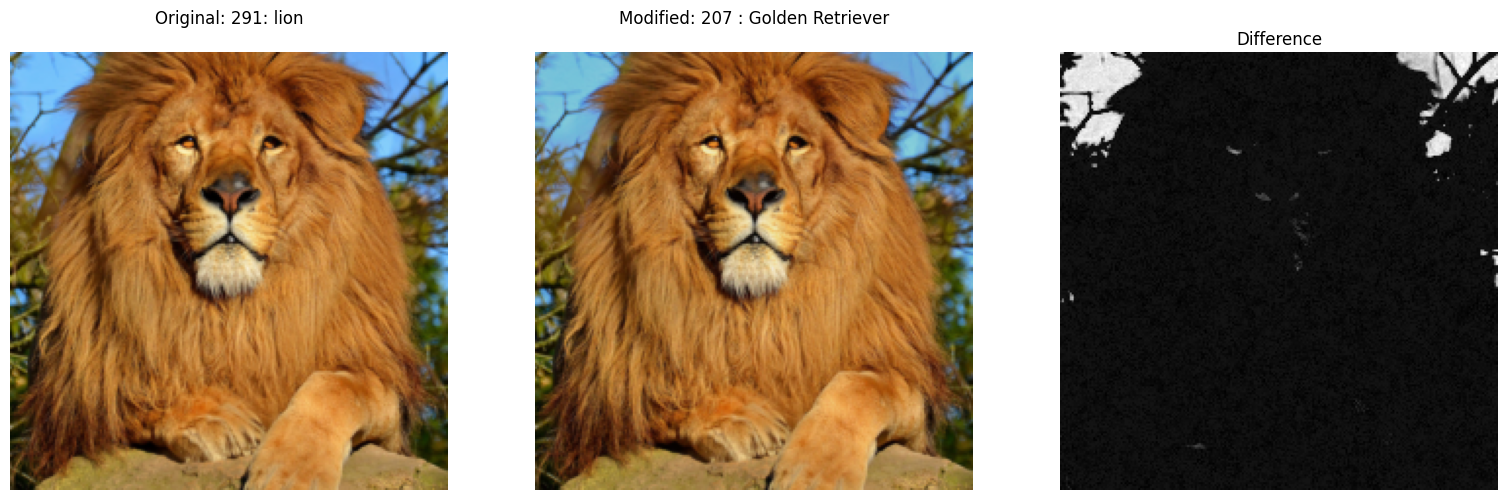

In [ ]:
if __name__ == "__main__":
    net = models.resnet18(pretrained=True)
    net.eval()
    path="/content/imagenet-simple-labels.json"

    tensor = read_image("/content/img.jpg")

    new_tensor, orig_prediction, new_prediction = attack(
            tensor, net, eps=1e-3, n_iter=100
            )
    orig_prediction_class = read_json_line(path, orig_prediction)
    new_prediction_class = read_json_line(path, new_prediction)

    _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
    arr = to_array(tensor)
    new_arr = to_array(new_tensor)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {orig_prediction}: {orig_prediction_class} ")
    ax_new.set_title(f"Modified: {new_prediction} : {new_prediction_class}")
    ax_diff.set_title("Difference")

    plt.savefig("res_1.png")

In [ ]:
import os

# Đường dẫn tới thư mục chứa 5 ảnh
image_folder = "/content/images"
# Tạo danh sách các tên tệp ảnh trong thư mục
image_files = os.listdir(image_folder)

# Lặp qua mỗi tệp ảnh
for image_file in image_files:
    # Đường dẫn đầy đủ tới ảnh
    image_path = os.path.join(image_folder, image_file)

    # Thực hiện các bước trong đoạn mã cho mỗi ảnh
    tensor = read_image(image_path)
    new_tensor, orig_prediction, new_prediction = attack(tensor, net, eps=1e-3, n_iter=100)
    orig_prediction_class = read_json_line(path, orig_prediction)
    new_prediction_class = read_json_line(path, new_prediction)

    _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
    arr = to_array(tensor)
    new_arr = to_array(new_tensor)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {orig_prediction}: {orig_prediction_class} ")
    ax_new.set_title(f"Modified: {new_prediction} : {new_prediction_class}")
    ax_diff.set_title("Difference")

    plt.savefig(f"res_{image_file.split('.')[0]}.png")


Output hidden; open in https://colab.research.google.com to view.